In [1]:
!wget https://raw.githubusercontent.com/carcrupe/physionet_challenge/master/get_12ECG_features.py
!wget https://raw.githubusercontent.com/carcrupe/physionet_challenge/master/evaluate_12ECG_score.py
!wget https://raw.githubusercontent.com/carcrupe/physionet_challenge/master/run_12ECG_classifier.py
!wget https://raw.githubusercontent.com/carcrupe/physionet_challenge/master/driver.py
!wget https://raw.githubusercontent.com/carcrupe/physionet_challenge/master/requirements.txt

--2020-06-21 19:10:40--  https://raw.githubusercontent.com/carcrupe/physionet_challenge/master/get_12ECG_features.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9776 (9.5K) [text/plain]
Saving to: ‘get_12ECG_features.py’

get_12ECG_features. 100%[===================>]   9.55K  --.-KB/s    in 0s      

2020-06-21 19:10:40 (59.4 MB/s) - ‘get_12ECG_features.py’ saved [9776/9776]

--2020-06-21 19:10:42--  https://raw.githubusercontent.com/carcrupe/physionet_challenge/master/evaluate_12ECG_score.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Len

In [2]:
!pip install -r requirements.txt

In [3]:
import numpy as np
import pandas as pd
import os
import sys
import tarfile
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fftpack import fft
import peakutils

from get_12ECG_features import get_12ECG_features,get_fft_peaks, bandpass_filter, findpeaks, get_diagnosis, detect_peaks
from driver import load_challenge_data, get_classes

import warnings
warnings.filterwarnings('ignore')


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
!wget -O PhysioNetChallenge2020_Training_CPSC.tar.gz \
https://cloudypipeline.com:9555/api/download/physionet2020training/PhysioNetChallenge2020_Training_CPSC.tar.gz/

--2020-06-21 19:11:03--  https://cloudypipeline.com:9555/api/download/physionet2020training/PhysioNetChallenge2020_Training_CPSC.tar.gz/
Resolving cloudypipeline.com (cloudypipeline.com)... 34.74.104.185
Connecting to cloudypipeline.com (cloudypipeline.com)|34.74.104.185|:9555... connected.
HTTP request sent, awaiting response... 200 
Length: 859952525 (820M) [application/octet-stream]
Saving to: ‘PhysioNetChallenge2020_Training_CPSC.tar.gz’

PhysioNetChallenge2 100%[===================>] 820.11M  30.6MB/s    in 28s     

2020-06-21 19:11:31 (29.5 MB/s) - ‘PhysioNetChallenge2020_Training_CPSC.tar.gz’ saved [859952525/859952525]



In [5]:
my_tar = tarfile.open('PhysioNetChallenge2020_Training_CPSC.tar.gz')
my_tar.extractall('./data') # specify which folder to extract to
my_tar.close()

In [6]:
input_files = []
input_directory = 'data/Training_WFDB/'

# Append all files in a list
for f in os.listdir(input_directory):
    if os.path.isfile(os.path.join(input_directory, f)) and not f.lower().startswith('.') and f.lower().endswith('mat'):
           input_files.append(f)

In [7]:
#Create a dictionary with classes, for visual purposes and undertand better the diagnosis
classes = get_classes(input_directory, input_files );
classes_dict = dict(zip(classes, ['PVC', 'AF', 'LBBB', 'STE' , 'IAVB', 'PAC', 'Normal', 'STD', 'RBBB' ]))
classes_dict

{'164884008': 'PVC',
 '164889003': 'AF',
 '164909002': 'LBBB',
 '164931005': 'STE',
 '270492004': 'IAVB',
 '284470004': 'PAC',
 '426783006': 'Normal',
 '429622005': 'STD',
 '59118001': 'RBBB'}

R peak values:  [3303.55494426 3390.33572328 2398.34516656 3011.50709253 3386.03321314
 2549.80125071 2630.31321239 3313.59142184 3416.17541889 2762.62764047
 2950.15468881 3372.43933402 3585.99375546 3489.72186044 2608.04038501
 3202.95190161 3386.65104793 3151.13811744 2685.74243496 3303.95983768
 3573.24655537 3423.31490928 2485.17522382 3223.18815616 3306.54421823
 3348.02639558 3289.71941305 2489.99140008]
R peak index:  [  233   739  1238  1740  2253  2758  3250  3756  4253  4736  5235  5729
  6236  6759  7288  7803  8319  8820  9308  9805 10313 10826 11315 11824
 12337 12842 13354 13851]
RR diff mean (ms):  1008.7407407407408


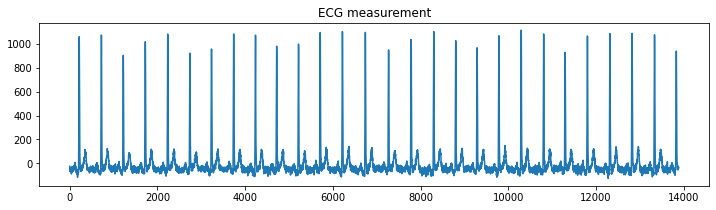

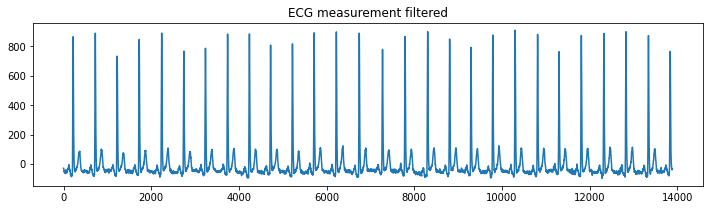

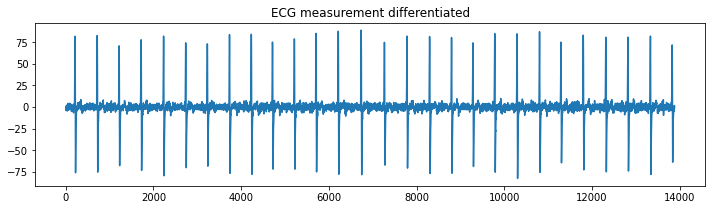

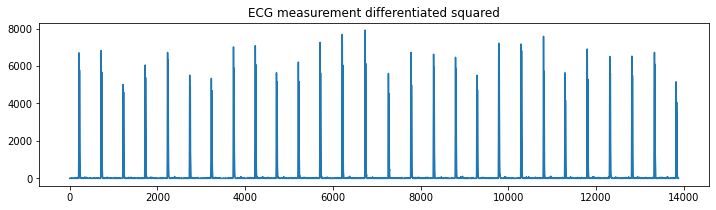

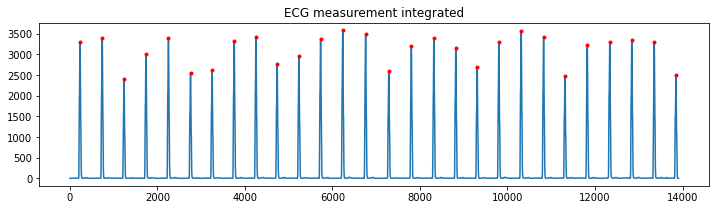

In [8]:
# Just for visualization purposes and better understand the feature extraction, I will
# plot the different signal processing steps to obtain the R peak information

tmp_input_file = os.path.join(input_directory, input_files[1])
data, header_data = load_challenge_data(tmp_input_file)

tmp_hea = header_data[0].split(' ')
num_leads = int(tmp_hea[1])
sample_Fs= int(tmp_hea[2])
gain_lead = np.zeros(num_leads)

for ii in range(num_leads):
    tmp_hea = header_data[ii+1].split(' ')
    gain_lead[ii] = int(tmp_hea[2].split('/')[0])
    
#   We are only using data from lead1
ecg_measurements,signal_frequency,gain = data[0],sample_Fs,gain_lead[0]

plt.figure(figsize=(12,3))
plt.plot(range(len(ecg_measurements)), ecg_measurements)
plt.title('ECG measurement')

#Parameters to isolate R peaks
filter_lowcut = 0.001
filter_highcut = 15.0
filter_order = 1
integration_window = 30  # Change proportionally when adjusting frequency (in samples).
findpeaks_limit = 100
findpeaks_spacing = 100  # Change proportionally when adjusting frequency (in samples).


# Measurements filtering - 0-15 Hz band pass filter.
filtered_ecg_measurements = bandpass_filter(ecg_measurements, lowcut=filter_lowcut, highcut=filter_highcut, signal_freq=signal_frequency, filter_order=filter_order)

filtered_ecg_measurements[:5] = filtered_ecg_measurements[5]
plt.figure(figsize=(12,3))
plt.plot(range(len(filtered_ecg_measurements)), filtered_ecg_measurements)
plt.title('ECG measurement filtered')


# Derivative - provides QRS slope information.
differentiated_ecg_measurements = np.ediff1d(filtered_ecg_measurements)
plt.figure(figsize=(12,3))
plt.plot(range(len(differentiated_ecg_measurements)), differentiated_ecg_measurements)
plt.title('ECG measurement differentiated')


# Squaring - intensifies values received in derivative.
squared_ecg_measurements = differentiated_ecg_measurements ** 2
plt.figure(figsize=(12,3))
plt.plot(range(len(squared_ecg_measurements)), squared_ecg_measurements)
plt.title('ECG measurement differentiated squared')


# Moving-window integration.
integrated_ecg_measurements_R = np.convolve(squared_ecg_measurements, np.ones(integration_window)/integration_window)


detected_peaks_indices_R = findpeaks(data=integrated_ecg_measurements_R,
                                             limit=findpeaks_limit,
                                             spacing=findpeaks_spacing)

detected_R_peak_values = integrated_ecg_measurements_R[detected_peaks_indices_R]

plt.figure(figsize=(12,3))
plt.plot(range(len(integrated_ecg_measurements_R)), integrated_ecg_measurements_R);
plt.plot(detected_peaks_indices_R, integrated_ecg_measurements_R[detected_peaks_indices_R], 'r.')
plt.title('ECG measurement integrated')

print ('R peak values: ',detected_R_peak_values)
print('R peak index: ',detected_peaks_indices_R)
print('RR diff mean (ms): ',  np.mean(np.diff(detected_peaks_indices_R)/sample_Fs*1000))


[28, 55, 83, 110, 133, 139, 165, 187, 194, 220, 248, 275, 303, 330, 358]
[83832.98086768229, 85991.76326621993, 87119.10610672199, 99629.70861829066, 125922.65062349649, 136177.24030270465, 142216.54114326206, 151666.272131441, 193997.3594680711, 200877.75030840226, 211300.76002955716, 212832.58250673054, 242655.24892924444, 302025.699245421, 392610.63685785583]
[28, 55, 83, 110]


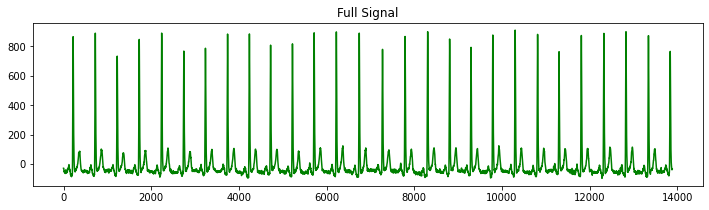

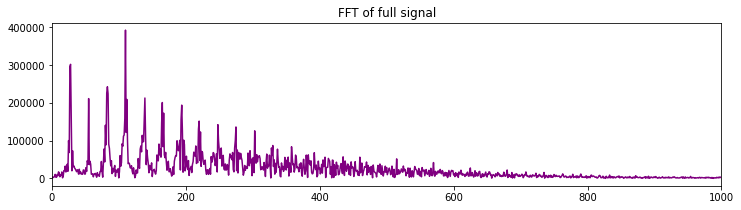

In [9]:
# For the FFT, I take the bandpassed filtered ecg signal from the previous step
full_signal_fft_values = np.abs(fft(filtered_ecg_measurements))
x_values_fft = range(0, len(filtered_ecg_measurements), 1)

peaks_ind = peakutils.indexes(full_signal_fft_values, thres=0.2, min_dist=5)
peaks_ind = [peak for peak in peaks_ind if peak < 1000]
print(peaks_ind)

sorted_amplitudes = sorted(full_signal_fft_values[peaks_ind])
four_highest_peaks = [peak for peak in peaks_ind if (full_signal_fft_values[peak] in sorted_amplitudes)][:4]
print(sorted_amplitudes)
print(four_highest_peaks)

plt.figure(figsize=(12,3))
plt.plot(x_values_fft, filtered_ecg_measurements, color = 'green')
plt.title('Full Signal')

plt.figure(figsize=(12,3))
plt.plot(x_values_fft, list(full_signal_fft_values), color = 'purple')
plt.xlim([0,1000])
plt.title('FFT of full signal');

In [10]:
# Load all data in a data frame with the diagnosis as the target column.
# I changed a little bit the feature extraction of the function get_12ECG_features, 
# it now takes into accout lead 1 of the ECG and makes calculations regarding the RR parameter,
# in amplitude and time difference between peaks. 

# Also, a simple FFT analysis for each lead 1 is done. The four highest FFT peaks are stored as features in the 
# data frame.This frequency information might add relevant information for the different arrythmias.

# To evaluate RR characteristics, taking into account only lead one, might be sufficient. 
# However, feature extraction could be improved by detecting other ECG relevant parameters, such as PR time, 
# ST time or width of the QRS complex. Taking into account these paramenters would improve the machine learning 
# model and predictions. 

# Note that RR information or the FFT peaks are not meaningful for some of the targeted arrythmias. 

df = pd.DataFrame(columns = ['age','sex','mean_RR_ms','mean_Peaks','median_RR_ms','median_Peaks',
                             'std_RR_ms','std_Peaks','skew_RR','skew_Peaks',
                             'kurt_RR','kurt_Peaks','first_fft_peak', 'second_fft_peak','third_fft_peak',
                             'forth_fft_peak', 'target'])

for i,f in enumerate(input_files):
    tmp_input_file = os.path.join(input_directory, f)
    data, header_data = load_challenge_data(tmp_input_file)
    
    #These features are only the ones related to lead 1
    features=list(get_12ECG_features(data, header_data))
    
    fft_peaks = get_fft_peaks(data,header_data)
   
    # Append the fft four highest peaks to the features
    [features.append(fft_peak) for fft_peak in fft_peaks]
    
    target = (get_diagnosis(header_data))
    features.append(classes_dict[target])
    df.loc[i] = (features)

In [11]:
# Remove rows with no R peaks detected, meaning NaN in the mean_RR_ms, for example
df[df['mean_RR_ms'].isna()].head()

,age,sex,mean_RR_ms,mean_Peaks,median_RR_ms,median_Peaks,std_RR_ms,std_Peaks,skew_RR,skew_Peaks,kurt_RR,kurt_Peaks,first_fft_peak,second_fft_peak,third_fft_peak,forth_fft_peak,target
10,25.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,22,44,65,STD
54,22.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,7,18,36,Normal
112,71.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14,23,35,44,PVC
215,75.0,0.0,NaN,127704.08054,NaN,127704.08054,NaN,0.0,NaN,0.0,NaN,-3.0,4,15,31,46,RBBB
276,60.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,20,0,0,RBBB


In [12]:
# 84 observations were removed, not very meaninful compared to the total number of rows
df.dropna(inplace=True)
df.shape

(6793, 17)

In [13]:
#Factorize categorical target for modeling
df['target'], label = pd.factorize(df['target'])

In [14]:
df.head()

,age,sex,mean_RR_ms,mean_Peaks,median_RR_ms,median_Peaks,std_RR_ms,std_Peaks,skew_RR,skew_Peaks,kurt_RR,kurt_Peaks,first_fft_peak,second_fft_peak,third_fft_peak,forth_fft_peak,target
0,52.0,0.0,813.804878,1.243797e+06,816.0,1.231867e+06,21.040286,114427.208290,0.192518,-0.205278,-0.697543,-1.028661,42,127,169,253,0
1,64.0,0.0,1008.740741,3.108510e+06,1010.0,3.296637e+06,21.047728,366339.375237,0.139121,-0.658068,-0.215783,-1.049662,28,55,83,110,1
2,79.0,1.0,522.981132,1.024813e+06,508.0,9.906175e+05,90.981750,187186.475394,0.817949,0.241043,0.551550,-0.694271,14,20,31,41,2
3,50.0,0.0,1073.636364,1.495986e+06,1070.0,1.595368e+06,44.938893,295643.679358,0.135473,-2.253656,-1.239965,4.241104,4,11,22,33,3
4,21.0,1.0,919.600000,5.104770e+05,1001.0,5.108242e+05,193.148233,143313.341608,-1.723235,-0.644890,1.755371,0.424492,4,10,21,29,2


In [15]:
label

Index(['Normal', 'IAVB', 'AF', 'RBBB', 'STE', 'STD', 'PVC', 'PAC', 'LBBB'], dtype='object')

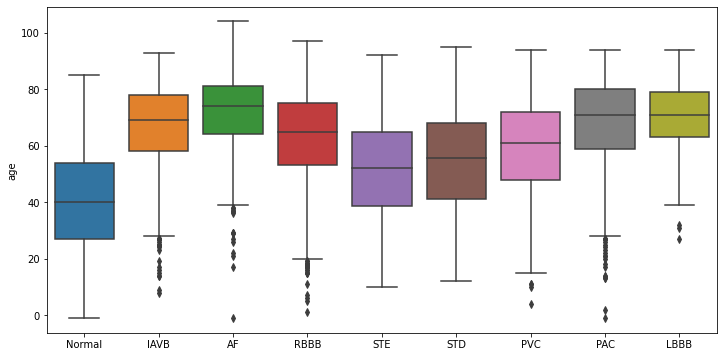

In [16]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=label[df['target']], y=df['age']);

We see that some arrythmias such as 1st degree AV block (IAVB), right bundle brach block (RBBB), premature atrial contraction (PAC) or atrial fibrilation (AF) are more common at ages higher than 60. However, they also have a lot of outliers, meaning there are very young patients suffering from these cardiac pathologies.

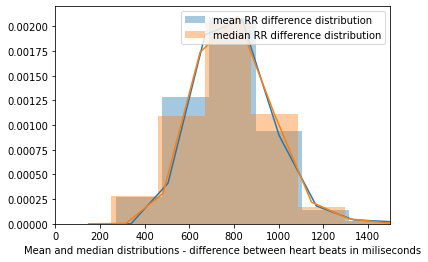

In [18]:
# Let us better understand the data by plotting some distributions 
sns.distplot(df['mean_RR_ms'],bins=100, label='mean RR difference distribution');
sns.distplot(df['median_RR_ms'],bins=100, label='median RR difference distribution');
plt.xlim([0,1500])
plt.xlabel('Mean and median distributions - difference between heart beats in miliseconds')
plt.legend();

Mean and median are very close, meaning we have a symmetric distribution. Also, it is interesting to see that the mean is around 800ms, corresponding to a normal sinus rythm. This result makes sense, taking into account that some of the targeted arrythmias do not affect the normal RR segment and the heart beat frequency does not change.

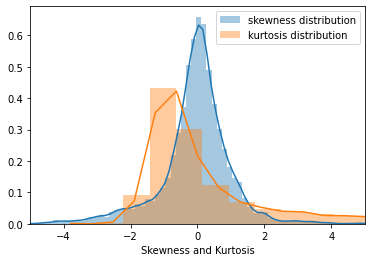

In [19]:
sns.distplot(df['skew_RR'],bins=100, label='skewness distribution');
sns.distplot(df['kurt_RR'],bins=100, label='kurtosis distribution');
plt.xlim([-5,5])
plt.xlabel('Skewness and Kurtosis')

plt.legend();

From these plots we confirm what we saw in the previous "RR time difference" distributions. There is a normal distribution. In addition, there is a negative kurtosis, around -0.75, meaning the tails of the RR distribution decrease slowly.

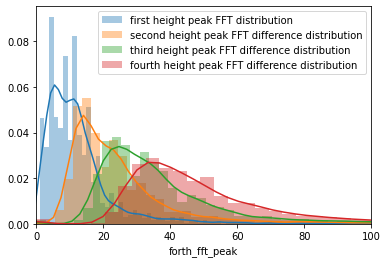

In [20]:
# Let us better understand the data by plotting some distributions 
sns.distplot(df['first_fft_peak'],bins=100, label='first height peak FFT distribution');
sns.distplot(df['second_fft_peak'],bins=100, label='second height peak FFT difference distribution');
sns.distplot(df['third_fft_peak'],bins=100, label='third height peak FFT difference distribution');
sns.distplot(df['forth_fft_peak'],bins=100, label='fourth height peak FFT difference distribution');
plt.xlim([0,100])
plt.legend();

We observe the distribution of the four main frequencies in our ECG lead 1. This might add meaningful information
for the modeling. The lower the frequency, the higher is the amplitude of the FFT.

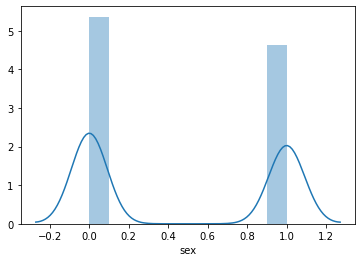

In [21]:
# confirmation that sex distribution is quite balanced in all observations
sns.distplot(df['sex'], norm_hist=True);

## Let us start modeling the classification problem


In [23]:
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [24]:
# Create target object and call it y
y = df['target']
# Create X
X = df.loc[:, df.columns != 'target']

#Scale the feature data before spliting
scaler = StandardScaler()
X_scaled = pd.DataFrame(data= scaler.fit_transform(X), columns=X.columns)

# Split into validation and training data
train_X, test_X, train_y, test_y = train_test_split(X_scaled, y, test_size=0.2, random_state=1)

#Create a data frame which will store all the model scores
model_score = pd.DataFrame(index = ['Model Score','Model'])

As a metric, I will optimize the accuracy of the model and will create a classification report.
After that, using cross validation I will get the score of the optimized model.

In the challenge, other metrics are defined, I run these evaluation at the end, after saving the model

# Decision tree classifier

In [25]:
from sklearn.tree import DecisionTreeClassifier

# Specify Model
tree_model = DecisionTreeClassifier(random_state=1)
# Fit Model
tree_model.fit(train_X, train_y)

# Make validation predictions and calculate accuracy for default model
predictions = tree_model.predict(test_X)
acc = accuracy_score(predictions, test_y)
print("Prediction accuracy for Decision Tree: {:,.3f}".format(acc))

Prediction accuracy for Decision Tree: 0.407


In [26]:
#Let us use Randomized Grid search to optimize several hyperparameters

# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_leaf_nodes" : np.arange(10,200,10),
              "max_depth": np.arange(1, 10),
              "max_features": np.arange(1, 9),
              "min_samples_leaf": np.arange(1, 9),
              "criterion": ["gini", "entropy"]}

tree_cv = RandomizedSearchCV(tree_model, param_dist, cv=5, random_state=1, scoring='accuracy')

# Fit it to the data
tree_cv.fit(train_X,train_y)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'min_samples_leaf': 6, 'max_leaf_nodes': 80, 'max_features': 4, 'max_depth': 7, 'criterion': 'gini'}
Best score is 0.4052265091716773


In [27]:
best_dt = tree_cv.best_estimator_.fit(train_X, train_y)

predictions = best_dt.predict(test_X)
print(classification_report(test_y,predictions))

              precision    recall  f1-score   support

           0       0.41      0.51      0.45       178
           1       0.32      0.08      0.13       140
           2       0.51      0.73      0.60       193
           3       0.40      0.56      0.47       339
           4       0.00      0.00      0.00        29
           5       0.43      0.20      0.27       173
           6       0.43      0.36      0.39       148
           7       0.37      0.42      0.39       120
           8       0.00      0.00      0.00        39

    accuracy                           0.42      1359
   macro avg       0.32      0.32      0.30      1359
weighted avg       0.39      0.42      0.39      1359



In [28]:
score = cross_val_score(best_dt, X_scaled, y, cv=5).mean()
score

0.4074771257129419

In [29]:
model_score['DecisionTree'] =  [score, best_dt]

# Random Forest Classifier

In [30]:
from sklearn.ensemble import RandomForestClassifier

# Define the model. Set random_state to 1
rf_model = RandomForestClassifier(random_state=1)

# fit the model
rf_model.fit(train_X,train_y)

# Calculate the accuracy of your Random Forest model 
predict_y=rf_model.predict(test_X)
rf_acc = accuracy_score(test_y,predict_y)

print("Prediction accuracy for Random Forest Model: {}".format(rf_acc))

Prediction accuracy for Random Forest Model: 0.5298013245033113


In [31]:
#Let us use Randomized Grid search to optimize several hyperparameters

# Setup the parameters and distributions 
param_dist = {"max_leaf_nodes" : np.arange(2,300,50),
              "max_depth": np.arange(10, 40,10),
              "max_features": np.arange(1, 9,2)}

# Create the RandomizedSearchCV object
forest_cv = RandomizedSearchCV(rf_model, param_dist, cv=5, random_state=1, scoring='accuracy')

# Fit it to the data
forest_cv.fit(train_X,train_y)

# Print the tuned parameters and score
print("Tuned Forest Parameters: {}".format(forest_cv.best_params_))
print("Best score is {}".format(forest_cv.best_score_))

Tuned Forest Parameters: {'max_leaf_nodes': 252, 'max_features': 3, 'max_depth': 30}
Best score is 0.4801269312026782


In [32]:
best_fr = forest_cv.best_estimator_.fit(train_X, train_y)

predictions = best_fr.predict(test_X)
print(classification_report(test_y,predictions))

              precision    recall  f1-score   support

           0       0.54      0.53      0.53       178
           1       0.59      0.12      0.20       140
           2       0.59      0.85      0.70       193
           3       0.44      0.66      0.53       339
           4       0.00      0.00      0.00        29
           5       0.65      0.34      0.44       173
           6       0.54      0.51      0.52       148
           7       0.49      0.57      0.52       120
           8       0.00      0.00      0.00        39

    accuracy                           0.52      1359
   macro avg       0.43      0.40      0.38      1359
weighted avg       0.51      0.52      0.48      1359



In [33]:
# Save the mean of the cross validation score
score = cross_val_score(best_fr,X_scaled, y, cv=3).mean()
score

0.48078852669157585

In [34]:
model_score['RandomForest'] =  [score, best_fr]

# K-Neighbors model

In [35]:
# Instantiate and fit a k-NN classifier to the unscaled data

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_X, train_y)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [36]:
predict_y=knn.predict(test_X)
acc = accuracy_score(test_y,predict_y)

print("Prediction accuracy for Knn model: {}".format(acc))

Prediction accuracy for Knn model: 0.3841059602649007


In [37]:
#Let us use Randomized Grid search to optimize number of neighbors hyperparameters

# Setup the parameters and distributions 
param_dist = {"n_neighbors" : np.arange(1,10)}

# Create the RandomizedSearchCV object, scoring the recall
knn_cv = RandomizedSearchCV(knn, param_dist, cv=5, random_state=1, scoring='accuracy')

# Fit it to the data
knn_cv.fit(train_X,train_y)

# Print the tuned parameters and score
print("Tuned Forest Parameters: {}".format(knn_cv.best_params_))
print("Best score is {}".format(knn_cv.best_score_))

Tuned Forest Parameters: {'n_neighbors': 9}
Best score is 0.4037547374716429


In [38]:
best_knn = knn_cv.best_estimator_.fit(train_X, train_y)

predictions = best_knn.predict(test_X)
print(classification_report(test_y,predictions))

              precision    recall  f1-score   support

           0       0.40      0.53      0.45       178
           1       0.26      0.19      0.22       140
           2       0.56      0.80      0.66       193
           3       0.38      0.47      0.42       339
           4       0.00      0.00      0.00        29
           5       0.38      0.27      0.32       173
           6       0.48      0.36      0.42       148
           7       0.47      0.32      0.38       120
           8       0.33      0.03      0.05        39

    accuracy                           0.42      1359
   macro avg       0.36      0.33      0.32      1359
weighted avg       0.40      0.42      0.40      1359



In [39]:
score = cross_val_score(best_knn, X_scaled, y, cv=5).mean()
score

0.4170469926665735

In [40]:
model_score['K-neighbors'] =  [score, best_knn]

# XGBoost

In [41]:
import xgboost as xgb
from xgboost import XGBClassifier

xgbModel = XGBClassifier()
xgbModel.fit(train_X,train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [42]:
#Do a simple precition before tuning the model to see the accuracy
predictions = xgbModel.predict(test_X)
acc = accuracy_score(predictions, test_y)
print("Prediction accuracy for XGBoost: {:,.3f}".format(acc))

Prediction accuracy for XGBoost: 0.511


In [43]:
#We have explored the data and got the test prediction error. Let us now tune the model to improve the performance
#tuning the hyperparameters

gbm_param_grid = {
    'n_estimators': np.arange(10,400,200),
    'learning_rate': np.arange(0.1,0.5,0.1)
}

# Perform random search of hyperparameteres
r_xgb = RandomizedSearchCV(estimator=xgbModel, param_distributions=gbm_param_grid, cv=3, 
                                    n_iter=5, verbose=1, random_state=42, n_jobs=-1, scoring='accuracy')

# Fit best_xgb to the data
r_xgb.fit(train_X,train_y)

# Print the best parameters
print("Best parameters found: ", r_xgb.best_params_)
print("Highest score: ", (r_xgb.best_score_))

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   45.0s finished


Best parameters found:  {'n_estimators': 210, 'learning_rate': 0.30000000000000004}
Highest score:  0.4839890839603778


In [44]:
best_xgb = r_xgb.best_estimator_.fit(train_X, train_y)

predictions = best_xgb.predict(test_X)
print(classification_report(test_y,predictions))

              precision    recall  f1-score   support

           0       0.55      0.56      0.55       178
           1       0.39      0.25      0.30       140
           2       0.68      0.81      0.74       193
           3       0.45      0.57      0.50       339
           4       0.53      0.28      0.36        29
           5       0.49      0.36      0.42       173
           6       0.58      0.54      0.56       148
           7       0.50      0.55      0.53       120
           8       0.58      0.18      0.27        39

    accuracy                           0.52      1359
   macro avg       0.53      0.46      0.47      1359
weighted avg       0.52      0.52      0.51      1359



In [45]:
score = cross_val_score(best_xgb, X_scaled, y, cv=3).mean()
score

0.48829638556723015

In [46]:
model_score['XGBBoost'] =  [score, best_xgb]

In [47]:
final_scores = pd.DataFrame(model_score).transpose()
final_scores.sort_values(by='Model Score',ascending=False, inplace=True)
final_scores

,Model Score,Model
XGBBoost,0.488296,"XGBClassifier(base_score=0.5, booster='gbtree'..."
RandomForest,0.480789,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w..."
K-neighbors,0.417047,"KNeighborsClassifier(algorithm='auto', leaf_si..."
DecisionTree,0.407477,"DecisionTreeClassifier(ccp_alpha=0.0, class_we..."


As we can see, the trained model performance is not very accurate. It is not surprising since we do not have a detailed data feature extraction. As I mentioned before, taking into account only R peak characteristics or some FFT properties of the ECG, is not enough to detect arrythmias.
In the dataframe features we should include information about P, QRS, T waves, time between waves, amplitude, etc. Extracting these features if quite complicated, considering the variability in morphology of all the ECG signals in the dataset. This is out of the scope of this first approach project. 

Just as an example, arrythmias such as atrial fibrilation are strongly related to the P wave a not realted to the R peaks of the ECG, and we have not included this information in the model. Therefore, the model does not learn about these features and will not detect AF accurately.

In [48]:
# RandomForest classifier has a bit lower performance than XGBoost, however, I have decided to take 
# the Randomforest, because it trains and runs faster, in case it needs to be retrained.
best_model = final_scores['Model']['RandomForest']

In [52]:
# I save the model with the scaling step in a pipeline
steps = [('scaler', StandardScaler()),
        ('model', best_model)]
        
# Create the pipeline
pipeline = Pipeline(steps)
pipeline.fit(train_X,train_y)

predictions = pipeline.predict(test_X)
acc = accuracy_score(predictions, test_y)
print("Prediction accuracy for Random Forest saved model: {:,.3f}".format(acc))

Prediction accuracy for Random Forest saved model: 0.517


In [53]:
# Save the best model for further predictions
import pickle
pickle.dump(pipeline,open("classifier.model","wb"))

In [54]:
# Execute driver.py using the saved classifier.model.
# The first argument is the data input folder and the second argument is the folder 
# where we save the predictions in the challenge format
!python driver.py ./data/Training_WFDB/ output

Loading 12ECG model...
Extracting 12ECG features...
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-package

In [55]:
# evaluate the output from your algorithm using multiple evaluation metrics that are described 
# on the webpage for the PhysioNet/CinC Challenge 2020.
!python evaluate_12ECG_score.py data/Training_WFDB/ output

AUROC|AUPRC|Accuracy|F-measure|Fbeta-measure|Gbeta-measure
0.502|0.131|0.804|0.037|0.058|0.019
